In [35]:
rdm.predict_dataset.mask.sum()

tensor(5792)

In [33]:
str(rdm.adata_path.with_name(rdm.adata_path.stem + '__preprocessed.h5ad'))

'/home/ec2-user/cell_census/tabula_sapiens__sample_donor_id__label_cell_type__preprocessed.h5ad'

In [36]:
obs_indices = rdm.predict_dataset.obs_indices
var_bool = rdm.predict_dataset.mask
adata = rdm.predict_dataset.adata

In [37]:
adata_predict = adata[obs_indices.detach_().numpy(), var_bool.detach_().numpy()]

In [42]:
adata_predict.layers['aaa'] = np.random.rand(369, 5792)

In [43]:
adata_predict.shape

(369, 5792)

In [2]:
import torch

In [7]:
torch.randint(1, (1,))[0]

tensor(0)

In [8]:
import hydra
from omegaconf import OmegaConf
from glob import  glob
from rosa import  predict


BASE_DIR = "/home/ec2-user/outputs/2023-03-14/19-24-09" # /home/ec2-user/ or /Users/nsofroniew/Documents/data/rosa/
# BASE_DIR = "/home/ec2-user/outputs/2023-03-11/22-50-56" # /home/ec2-user/ or /Users/nsofroniew/Documents/data/rosa/
# BASE_DIR = "/home/ec2-user/outputs/2023-03-10/16-43-07" # /home/ec2-user/ or /Users/nsofroniew/Documents/data/rosa/
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    # chkpts = BASE_DIR + "/checkpoints/epoch=*.ckpt"
    chkpts = BASE_DIR + "/checkpoints/last.ckpt"
    chkpt = glob(chkpts)[0]

    # config.device = 'cpu'
    # config.num_devices = 32
    # config.preprocessing.bulk_data.sample_col = 'donor_id'
    adata, rdm, rlm = predict(config, chkpt)
    nbins = config.data_module.data.expression_transform.n_bins
# display(adata)
print(chkpt)

/tmp/ipykernel_59585/3194850428.py:12: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):
/home/ec2-user/rosa/rosa/data/datasets.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask[torch.tensor(mask).long()] = True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


RosaLightningModule(
  (model): RosaTransformer(
    (main): Sequential(
      (dual_embed): ParallelEmbed(
        (models): ModuleList(
          (0): Sequential(
            (input_embed_0): MaskedEmbed(
              (model): Sequential(
                (projection): Embedding(17, 320)
                (layer_norm): Identity()
                (dropout): Dropout(p=0, inplace=False)
              )
            )
          )
          (1): Sequential(
            (layer_norm_1): Identity()
            (input_embed_1): InputEmbed(
              (model): Sequential(
                (projection): Linear(in_features=3072, out_features=320, bias=True)
                (layer_norm): Identity()
                (dropout): Dropout(p=0, inplace=False)
              )
            )
          )
        )
      )
      (join_embeds): AddEmbeds()
    )
    (transformer): Performer(
      (net): SequentialSequence(
        (layers): ModuleList(
          (0): ModuleList(
            (0): PreLayerNorm(

/home/ec2-user/rosa/rosa/data/datasets.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask[torch.tensor(mask).long()] = True
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

/home/ec2-user/outputs/2023-03-14/19-24-09/checkpoints/last.ckpt


In [9]:
from rosa.utils import score_predictions, plot_expression_and_correlation, plot_marker_gene_heatmap


adata_test, results = score_predictions(adata, nbins=nbins)
predicted = adata_test.layers['predicted']
measured = adata_test.layers['measured']
confidence = adata_test.layers['confidence']

/opt/conda/envs/pytorch/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())



        mean spearmanr across genes -0.002
        mean spearmanr across cells 0.158
        mean square error 62.367
        ks-statistic on total expression 0.327
        mean percent total expression captured per cell 134.386
        

            accuracy 0.174
            precision 0.046
            recall 0.065
            fscore 0.043
            


/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


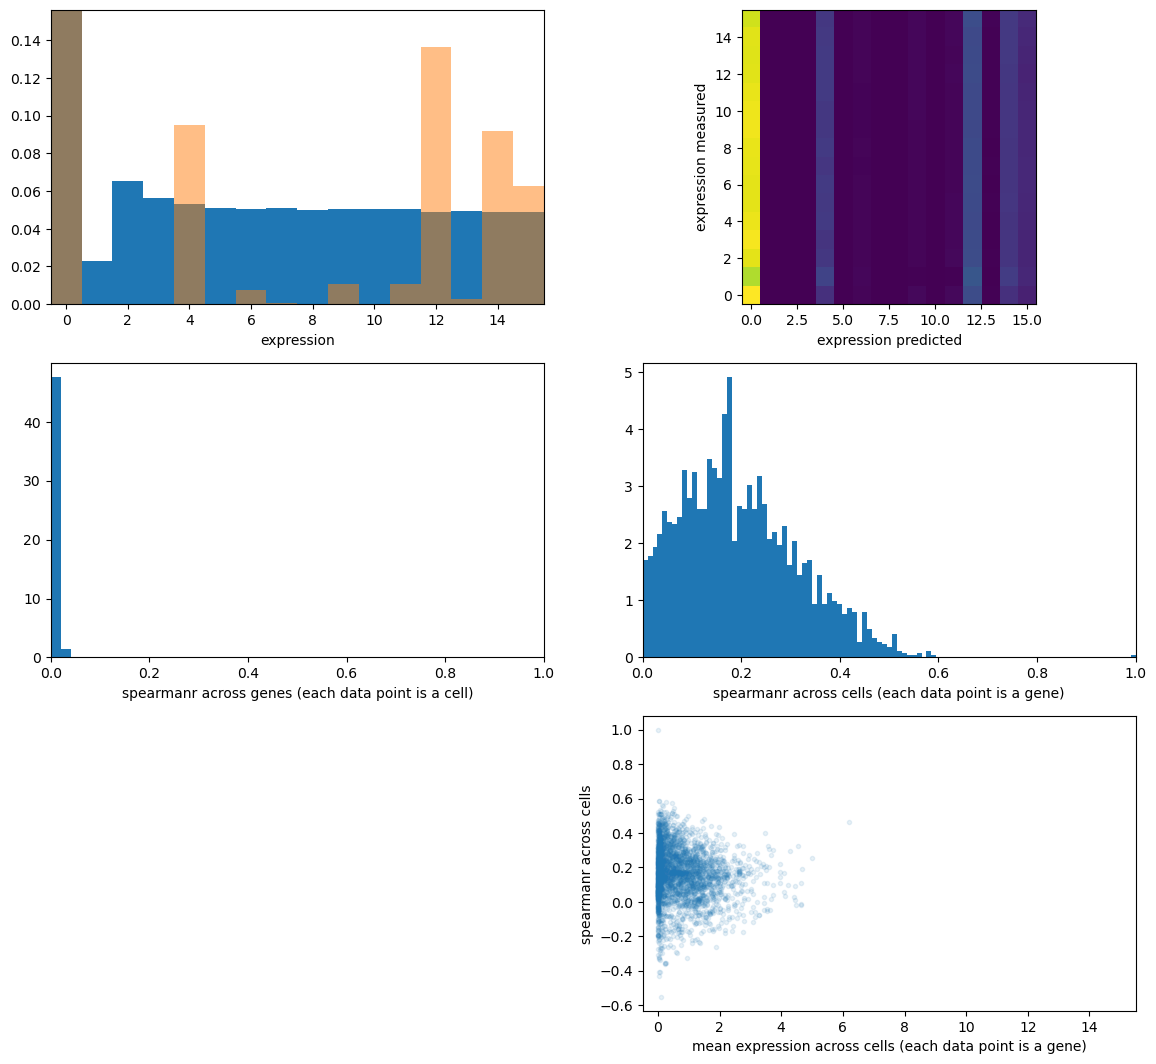

In [10]:
if nbins is not None:
    mev = config.data_module.data.expression_transform.n_bins - 1
else:
    mev = 6
    
plot_expression_and_correlation(adata_test, results, max_expression_val=mev, nbins=nbins)

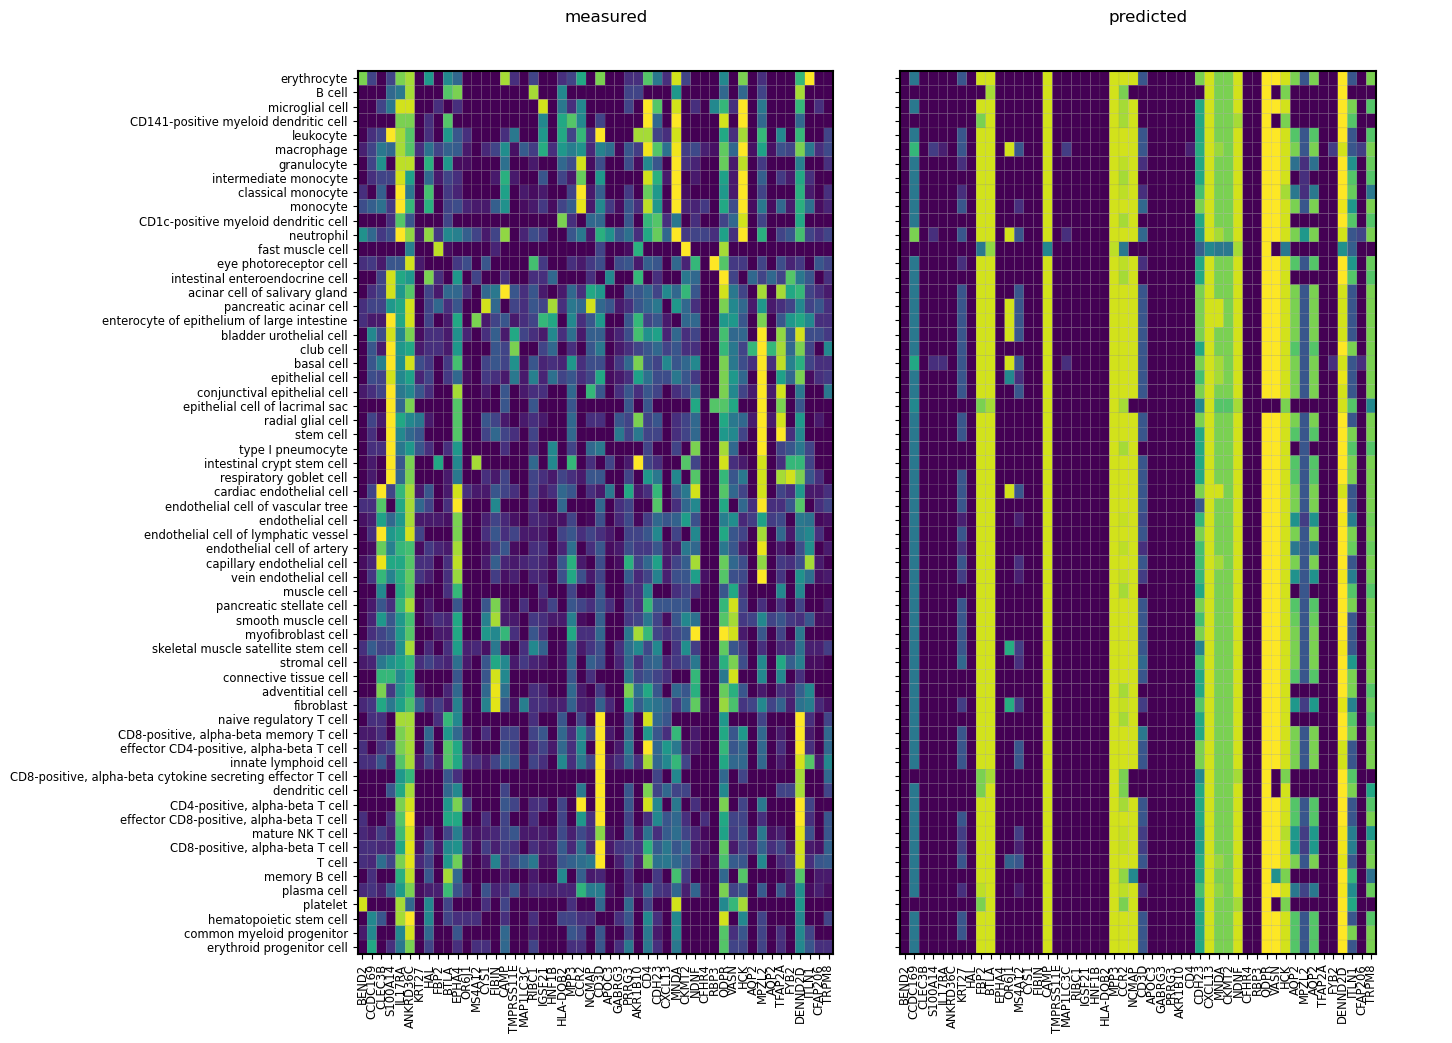

In [11]:
import numpy as np


marker_genes = adata_test.var[adata_test.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_test, marker_genes, max_expression_val=mev)

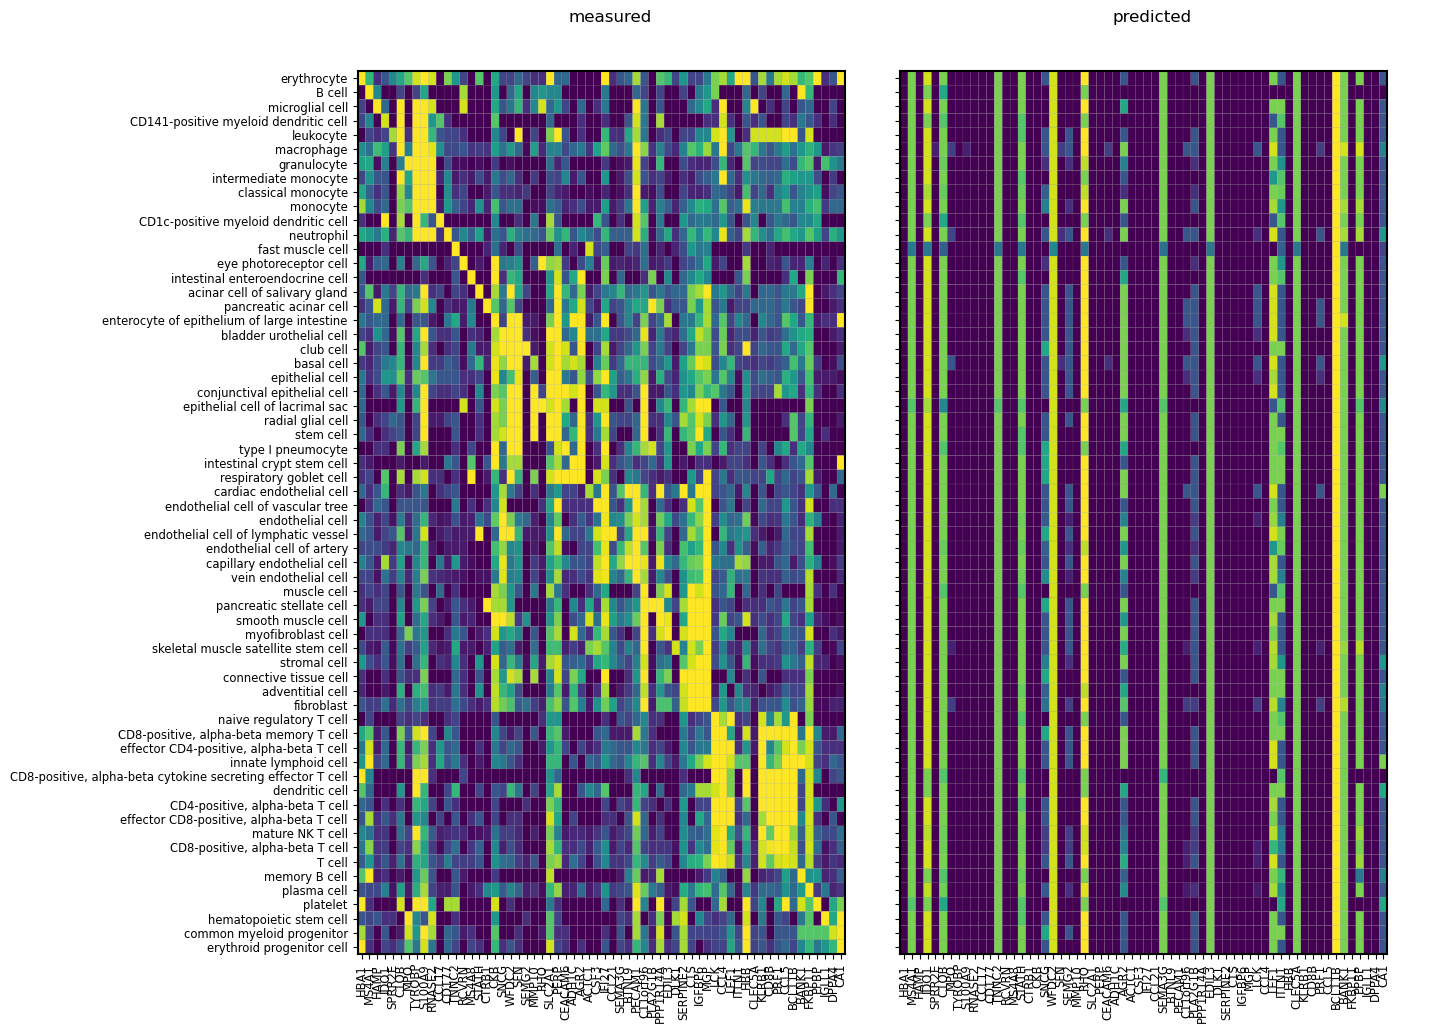

In [12]:
marker_genes_dict = adata_test.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_test, marker_genes_dict, max_expression_val=mev)

In [13]:
import seaborn as sns
from scipy.cluster.hierarchy import linkage
import sys


sys.setrecursionlimit(100000)

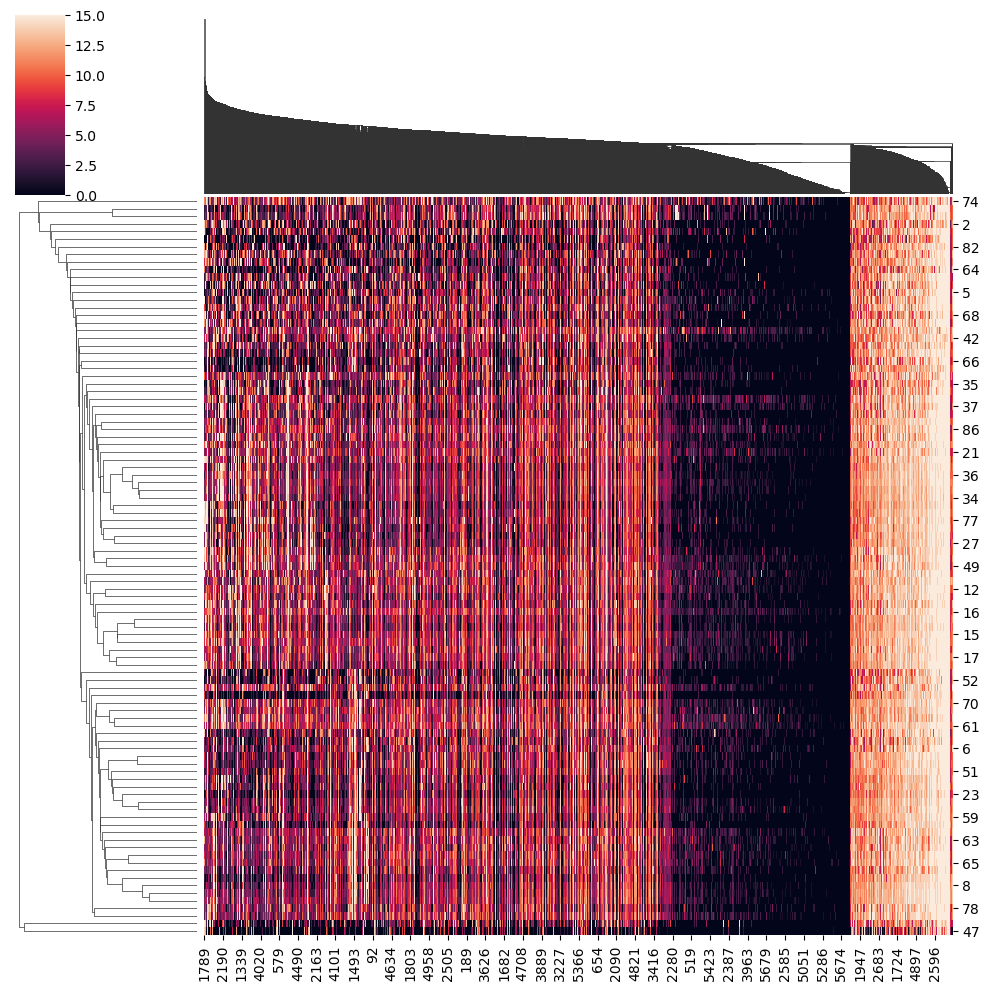

In [14]:
row_linkage = linkage(measured) # D being the measurement
col_linkage = linkage(measured.T) # D being the measurement
sns.clustermap(measured, row_linkage=row_linkage, col_linkage=col_linkage)

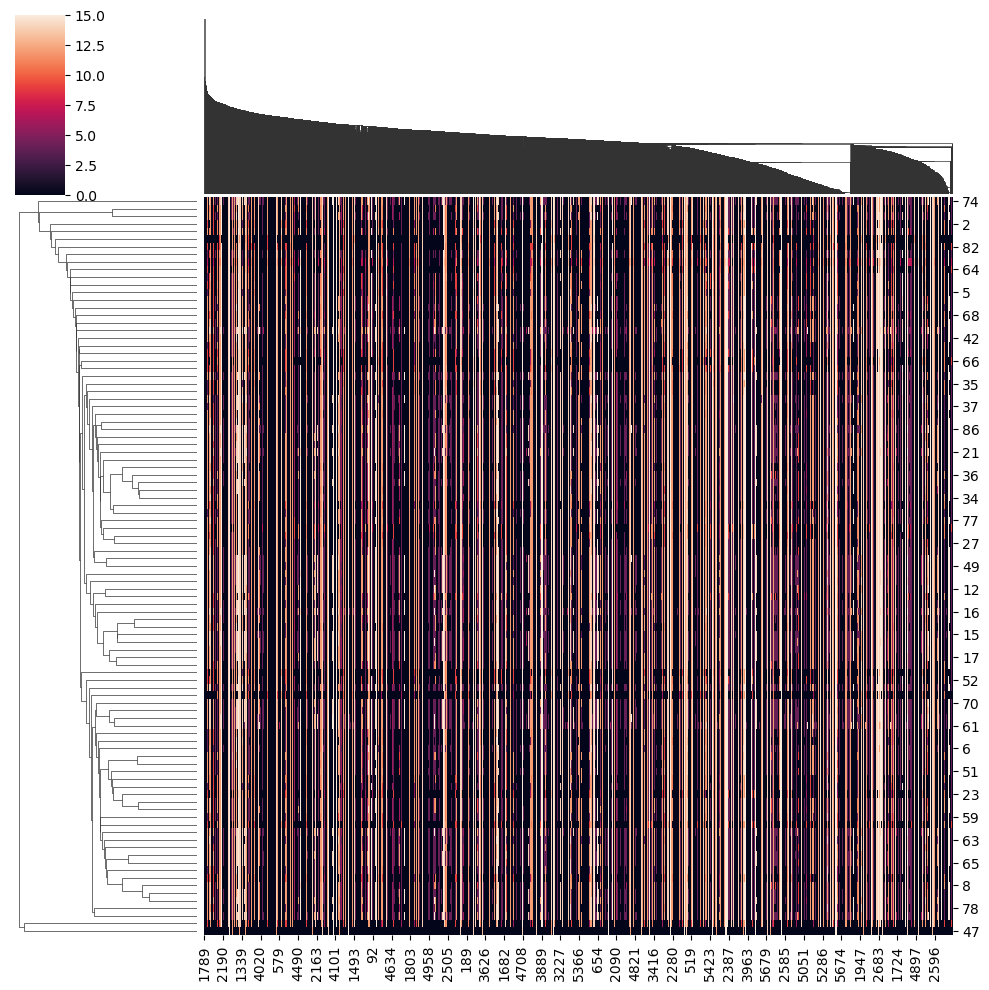

In [15]:
sns.clustermap(predicted, row_linkage=row_linkage, col_linkage=col_linkage)

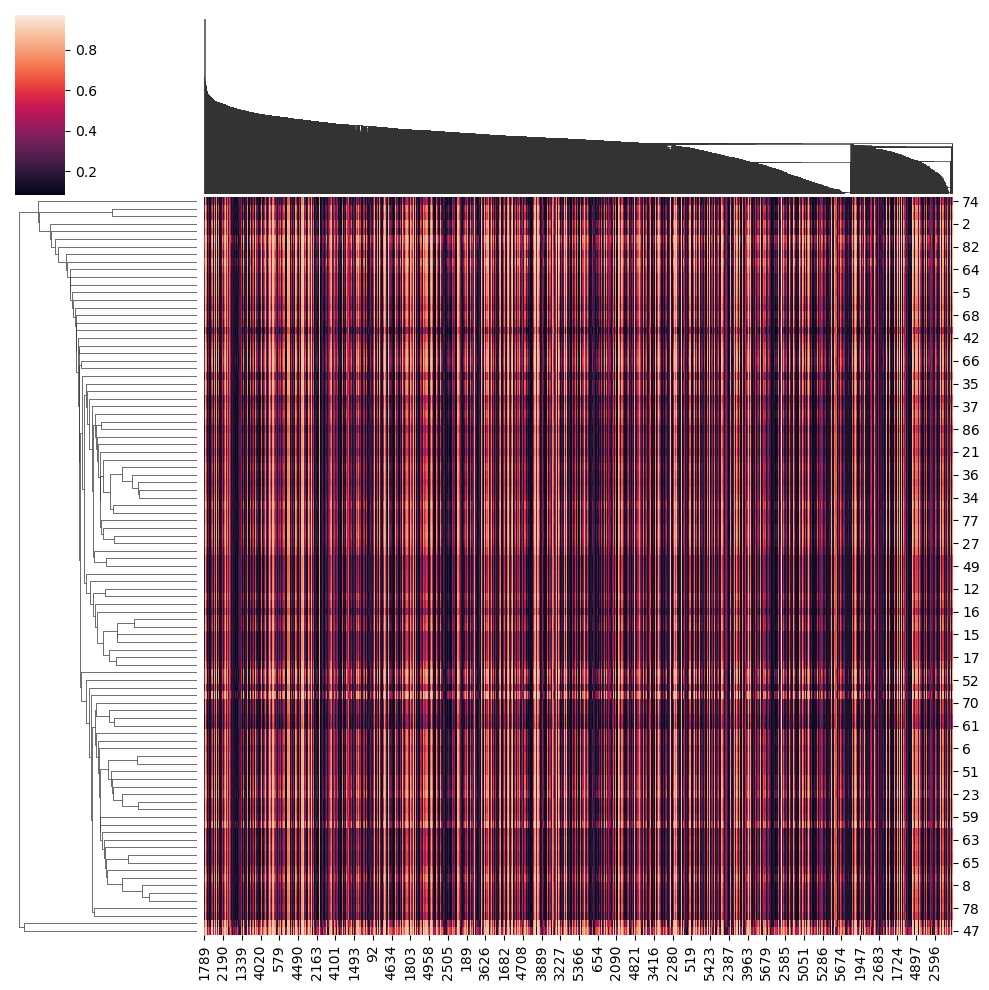

In [16]:
sns.clustermap(confidence, row_linkage=row_linkage, col_linkage=col_linkage)